In [236]:
###################################################################################################
###                             Motif Enrichment                                ###
###################################################################################################

#load libraries
library(tidyverse)
library(devtools)
library(motifmatchr)
library(BiocParallel)
load_all('/home/jpm73279/genome_downloads/BS_genomes/BSgenome.Zm_B73')
load_all("/home/jpm73279/genome_downloads/BS_genomes/BSgenome.Os")
load_all("/home/jpm73279/genome_downloads/BS_genomes/BSgenome.Pm")
load_all("/home/jpm73279/genome_downloads/BS_genomes/BSgenome.Sb")
load_all("/home/jpm73279/genome_downloads/BS_genomes/BSgenome.Uf")

library(Matrix)
library(GenomicAlignments)
library(dplyr)
library(universalmotif)  # manipulating motif representations
library(nullranges)



ℹ Loading BSgenome.Zm_B73
ℹ Loading BSgenome.Os
ℹ Loading BSgenome.Pm
ℹ Loading BSgenome.Sb
ℹ Loading BSgenome.Uf


In [237]:

## Load Markers for All Species
marker_file_paths <- c("/home/jpm73279/genome_downloads/C4_markers/Os.c4_markers.bed",
                "/home/jpm73279/genome_downloads/C4_markers/Pm.c4_markers.bed",
                "/home/jpm73279/genome_downloads/C4_markers/Sb.c4_markers.bed",
                "/home/jpm73279/genome_downloads/C4_markers/Uf.c4_markers.bed",
                "/home/jpm73279/genome_downloads/C4_markers/Zm.c4_markers.bed")

# Function to read and process the file
process_file <- function(file_path) {
  species <- substr(basename(file_path), 1, 2)
  read_delim(file_path, delim = "\t", col_names = c("chrom", "start", "end", "geneID", "name", "type")) %>% 
    dplyr::select("chrom","start","end","geneID","name","type") %>%
    dplyr::mutate(species = (species))
}

# Apply the function to each file and store results in a list
list_of_dataframes <- lapply(marker_file_paths, process_file)

# Optionally combine all dataframes into one if needed
markers <- bind_rows(list_of_dataframes) %>% 
    dplyr::select(geneID,name,type,species) 


Rows: 30 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 52 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 33 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 31 Columns: 6

In [238]:
### Load Motifs for Analysis
core_motifs <- read_meme("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/00.data/conserved_consensus_motifs_Fig2B.meme")
de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/combined_unique_motifs.meme")
ms_de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/Ms.specific_CGTCGT_motif.comparative.meme")

all_assy_motifs <- c(core_motifs, de_novo_motifs, ms_de_novo_motifs)
all_assy_motifs_converted <- convert_motifs(all_assy_motifs, class = "TFBSTools-PWMatrix")

update_name <- function(pwm) {
    if (!is.null(pwm@name)) {
        pwm@ID <- pwm@name
    }
    return(pwm)
}


### Update the Names to be the actual IDs, as well as convert to PWM matrix List (Nasty as fuck)
library(TFBSTools)
pw_matrix_list_converted <- lapply(all_assy_motifs_converted, update_name)
pw_matrix_list_converted <- lapply(pw_matrix_list_converted, PWMatrixList)
pw_matrix_list_converted <- do.call(c, pw_matrix_list_converted)


#Generate an Index Annotation name for later usage. Will be used because we need to rip these to annotate the Granges objects
#later
extractIDDataFrame <- function(pwMatrixList) {
  ids <- sapply(pwMatrixList@listData, function(item) item@ID)
  ids <- gsub("chr", "", ids, fixed = TRUE)
  indices <- seq_along(ids)
  
  data.frame(group = indices, TF_ID = ids)
}

# Example usage:
# Assuming your PWMatrixList object is named pwMatrixListObject
motif_id_index <- extractIDDataFrame(pw_matrix_list_converted)

In [239]:
sb_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/sb_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
pm_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/pm_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
zm_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/zm_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
uf_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/uf_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))
os_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/copy_over/os_acr_classification.no_exons.all_ACRs.classified.sorted.bed", col_names = c("chr", "start", "end", "acr_id", "score"))



Rows: 51387 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, acr_id, score
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 65990 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, acr_id, score
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 55504 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, acr_id, score
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 29153 Columns: 5
── Colum

In [240]:
header_bed <- c('chr','start','end','id','score')
zm_acr_intersections <- read_delim("/home/jpm73279/genome_downloads/C4_markers/conservation/zm.all_intersection_acr.intersection.bed", 
            col_names = header_bed) %>% 
    separate(id, into = c("acr", "acr_cell_type_specific_class", "locus"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    tidyr::separate(locus, into = c("species_other", "loci"), sep = "__",remove = FALSE) %>%
    tidyr::separate(loci, into = c("gene_family", "number"), sep = "_", remove = FALSE)

combined_acrs_marker_info <- left_join(zm_acr_intersections, markers, by = c("locus" = "name")) %>% 
    select(acr,acr_cell_type_specific_class, locus, gene_family, type)


Rows: 146 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chr, id, score
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [241]:
GetGC <- function(bsgenome, gr){

  seqs <- BSgenome::getSeq(bsgenome, gr)
  return(as.numeric(Biostrings::letterFrequency(x = seqs, letters = "GC", as.prob = TRUE)))


}

In [242]:
zm_peaks_gr <- GRanges(zm_acrs, seqinfo=seqinfo(BSgenome.Zm_B73))
zm_gc_content_acrs <- GetGC(BSgenome.Zm_B73, zm_peaks_gr)
zm_peaks_gr$GC <- zm_gc_content_acrs

names(zm_peaks_gr) <- as.character(zm_peaks_gr)
zm_peaks_gr <- unique(zm_peaks_gr)

# get peak sequences, we'll need this later
zm_peak_seqs <- getSeq(BSgenome.Zm_B73, zm_peaks_gr) # <2s


# exclude peaks with any N's, to avoid warnings further down
hasNs    <- (alphabetFrequency(zm_peak_seqs)[,"N"]>0)
addmargins(table(hasNs)) # => only drops 5 sequences

zm_peak_seqs <- zm_peak_seqs[!hasNs]
zm_peak_seqs  <- zm_peak_seqs[!hasNs]



hasNs
FALSE   Sum 
55504 55504 

In [296]:
keep_array <- c("ZM__AlaAT_6",
                "ZM__AlaAT_3",
                "Zm__AspAT_1",
                "Zm__AspAT_2",
                "Zm__CA_1",
                "Zm__CA_2",
                "Zm__NADME_1",
                "Zm__NADPMDH_1",
                "Zm__NADPME_1",
                "Zm__DIT_2",
                "Zm__DIT_1",
"Zm__PEPC_1",
"Zm__PEPCK_1",
"Zm__PPDK_1",
"Zm__PPDKRP_1",
"Zm__PPT_1",
"Zm__RBCS_1",
"Zm__RBCS_2",
"Zm__RCA_1"                
)

In [297]:
zm_acrs_TFs <- as_tibble(as.data.frame(zm_peaks_gr)) %>% 
    tidyr::separate(acr_id, into = c("acr", "acr_cell_type_specific_class"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    left_join(., combined_acrs_marker_info, by = c("acr", "acr_cell_type_specific_class")) %>% 
    mutate(locus = case_when(is.na(locus) == TRUE ~ "None",
                            TRUE ~ locus),
           gene_family = case_when(is.na(gene_family) == TRUE ~ "None",
                            TRUE ~ gene_family),
           type = case_when(is.na(type) == TRUE ~ "None",
                            TRUE ~ type),
          bool_type = case_when(type == "None" ~ FALSE,
                                type != "None" ~ TRUE)) %>% 
    dplyr::filter((type == "None" &  acr_cell_type_specific_class == "broadly_accessible")| 
                  type != "None" &  acr_cell_type_specific_class %in% c("mesophyll", "bundle_sheath", "broadly_accessible") ) %>% 
    dplyr::filter(type != "None" & locus %in% keep_array | type == "None")
                                

In [298]:
unique(zm_acrs_TFs$gene_family)

[1] "None"    "PEPCK"   "DIT"     "NADPMDH" "PPT"     "RBCS"    "PPDKRP" 
 [8] "NADPME"  "CA"      "RCA"     "NADME"   "AlaAT"   "AspAT"   "PPDK"   
[15] "PEPC"

In [315]:
zm_acrs_TFs %>% 
    dplyr::group_by(type, acr_cell_type_specific_class) %>% 
    summarise(n())

`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.


type,acr_cell_type_specific_class,n()
<chr>,<chr>,<int>
None,broadly_accessible,44562
bundle_sheath,broadly_accessible,11
bundle_sheath,bundle_sheath,18
bundle_sheath,mesophyll,3
mesophyll,broadly_accessible,27
mesophyll,mesophyll,14
"mesophyll,bundle_sheath",broadly_accessible,8


In [245]:
## Score Real ACRs Around our regions of interest values 

In [300]:

zm_acrs_c4_regions <- zm_acrs_TFs %>% 
    dplyr::filter(type != "None")

zm_c4_peaks_gr <- GRanges(zm_acrs_c4_regions, seqinfo=seqinfo(BSgenome.Zm_B73))

names(zm_c4_peaks_gr) <- as.character(zm_c4_peaks_gr)
zm_c4_peaks_gr <- unique(zm_c4_peaks_gr)

# Get peak sequences
peak_seqs <- getSeq(BSgenome.Zm_B73, zm_c4_peaks_gr)

# Exclude peaks with any N's
hasNs <- (alphabetFrequency(peak_seqs)[,"N"] > 0)
peak_seqs <- peak_seqs[!hasNs]

# Run matchMotifs
system.time(
    c4_motif_matches <- matchMotifs(
    pw_matrix_list_converted, 
    zm_c4_peaks_gr, 
    genome = BSgenome.Zm_B73,  
    p.cutoff = .001, # using a stringent p-value
    out="positions"
    ))

assign_motif_ids_intersect_regions <- function(granges_list, zm_c4_peaks_gr, motif_IDs) {
    for (i in seq_along(granges_list)) {
        # Assign motif IDs to each GRanges element
        granges_list[[i]]$TF_ID <- motif_IDs[i]
        
        # Find overlaps with the provided peaks GRanges
        overlaps <- findOverlaps(granges_list[[i]], zm_c4_peaks_gr)
        
        # Extract and annotate acr values based on overlaps
        ids <- zm_c4_peaks_gr$acr[subjectHits(overlaps)]
        granges_list[[i]]$acr <- ids[queryHits(overlaps)]
    }
    
    return(granges_list)
}

granges_list_c4 <- assign_motif_ids_intersect_regions(c4_motif_matches,
                                                      zm_c4_peaks_gr, 
                                                      motif_IDs)

# Convert to tibble and join with null_samples
zm_acrs_TFs_c4_prescence <- as_tibble((granges_list_c4)) %>% 
    left_join(., as_tibble(zm_c4_peaks_gr), by = c("acr"))

    # Count numbers
real_count_numer <- zm_acrs_TFs_c4_prescence %>% 
        dplyr::group_by(TF_ID, type, locus) %>% 
        summarise(counts = n()) %>% 
        dplyr::ungroup() %>% 
    mutate(sample = "real")

   user  system elapsed 
  0.469   0.002   0.474 

`summarise()` has grouped output by 'TF_ID', 'type'. You can override using the
`.groups` argument.


In [306]:
# generate_bootstrap_analysis <- function(zm_acrs_all, 
#                                         pw_matrix_list_converted, 
#                                         motif_id_index, 
#                                         BSgenome.Zm_B73, 
#                                         filter_type, 
#                                         filter_value, covariate = ~GC, 
#                                         p_cutoff = .001, 
#                                         num_bootstraps = 10) {
#     null_indices_list <- vector("list", num_bootstraps)

#     for(bootstrap_iter in 1:num_bootstraps) {
#         # Apply dynamic filtering based on passed arguments
#         focal_filter <- zm_acrs_all$type == filter_type

#         # Generate null_samples
#         null_samples <- matchRanges(focal = zm_acrs_all[focal_filter, ], 
#                                     pool = zm_acrs_all[!zm_acrs_all$bool_type, ],
#                                     covar = covariate)

#         # Process the null_samples
#         null_samples <- unique(null_samples)
#         peak_seqs <- getSeq(BSgenome.Zm_B73, null_samples)
#         hasNs <- (alphabetFrequency(peak_seqs)[,"N"] > 0)
#         peak_seqs <- peak_seqs[!hasNs]

#         # Run matchMotifs
#         system.time({
#             motif_matches <- matchMotifs(
#                 pw_matrix_list_converted, 
#                 null_samples, 
#                 genome = BSgenome.Zm_B73, 
#                 p.cutoff = p_cutoff, 
#                 out = "positions"
#             )
#         })

#         # Annotate and process GRanges list
#         motif_IDs <- motif_id_index$TF_ID
#         granges_list <- motif_matches
#         for (i in seq_along(granges_list)) {
#             granges_list[[i]]$TF_ID <- motif_IDs[i]
            
#             overlaps <- findOverlaps(granges_list[[i]], null_samples)
#             ids <- null_samples$acr[subjectHits(overlaps)]
#             granges_list[[i]]$acr <- ids[queryHits(overlaps)]
#         }

#         # Convert to tibble and perform join and count operations
#         zm_acrs_TFs <- as_tibble(granges_list) %>% 
#             left_join(., as_tibble(null_samples), by = c("acr"))

#         count_numer <- zm_acrs_TFs %>% 
#             dplyr::group_by(TF_ID, type) %>% 
#             summarise(counts = n()) %>% 
#             dplyr::ungroup()
        
#         null_indices_list[[bootstrap_iter]] <- count_numer
#     }
    
#     return(null_indices_list)
# }


In [329]:
x <- zm_acrs_all %>% 
    dplyr::filter(locus != "None")
unique(x$locus)

[1] "Zm__PEPCK_1"   "ZM__AlaAT_2"   "Zm__DIT_2"     "Zm__NADPMDH_1"
 [5] "Zm__PPT_1"     "ZM__BASS_1"    "Zm__RBCS_2"    "Zm__CA_4"     
 [9] "Zm__DIT_1"     "Zm__PPDKRP_1"  "ZM__AlaAT_7"   "ZM__AlaAT_5"  
[13] "Zm__NADPME_1"  "Zm__AspAT_3"   "Zm__CA_2"      "Zm__CA_1"     
[17] "Zm__RCA_1"     "Zm__RBCS_1"    "Zm__NADME_1"   "ZM__AlaAT_1"  
[21] "ZM__AlaAT_3"   "Zm__AspAT_1"   "Zm__DIC_1"     "Zm__NADPME_2" 
[25] "Zm__PPDK_1"    "Zm__NADMDH_1"  "ZM__AlaAT_6"   "Zm__NHD_1"    
[29] "ZM__AlaAT_4"   "Zm__NADMDH_2"  "Zm__AspAT_2"   "Zm__CA_3"     
[33] "Zm__PEPC_1"

In [476]:
# generate_bootstrap_analysis_per_gene <- function(zm_acrs_all, 
#                                         pw_matrix_list_converted, 
#                                         motif_id_index, 
#                                         BSgenome.Zm_B73, 
#                                         filter_type, 
#                                         filter_value, covariate = ~GC, 
#                                         p_cutoff = .001, 
#                                         num_bootstraps = 10) {
#     results_per_gene <- list()
# #     gene_models <- c("ZM__AlaAT_6",
# #                 "ZM__AlaAT_3",
# #                 "Zm__AspAT_1",
# #                 "Zm__AspAT_2",
# #                 "Zm__CA_1",
# #                 "Zm__CA_2",
# #                 "Zm__NADME_1",
# #                 "Zm__NADPMDH_1",
# #                 "Zm__NADPME_1",
# #                 "Zm__DIT_2",
# #                 "Zm__DIT_1",
# #                 "Zm__PEPC_1",
# #                 "Zm__PEPCK_1",
# #                 "Zm__PPDK_1",
# #                 "Zm__PPDKRP_1",
# #                 "Zm__PPT_1",
# #                 "Zm__RBCS_1",
# #                 "Zm__RBCS_2",
# #                 "Zm__RCA_1"                
# #         )
    
#     unique_loci <- unique(zm_acrs_all$locus)
#     gene_models <- unique_loci[unique_loci != "None"]

#     for(gene_model in gene_models) {
#         null_indices_list <- vector("list", num_bootstraps) 

#         for(bootstrap_iter in 1:num_bootstraps) {
#             # Apply dynamic filtering based on passed arguments
#             focal_filter <- zm_acrs_all$gene_model == gene_model


#         # Generate null_samples
#         null_samples <- matchRanges(focal = zm_acrs_all[zm_acrs_all$locus == gene_model, ], 
#                                     pool = zm_acrs_all[!zm_acrs_all$bool_type, ],
#                                     covar = covariate)

#         # Process the null_samples
#         null_samples <- unique(null_samples)
#         peak_seqs <- getSeq(BSgenome.Zm_B73, null_samples)
#         hasNs <- (alphabetFrequency(peak_seqs)[,"N"] > 0)
#         peak_seqs <- peak_seqs[!hasNs]

#         # Run matchMotifs
#         system.time({
#             motif_matches <- matchMotifs(
#                 pw_matrix_list_converted, 
#                 null_samples, 
#                 genome = BSgenome.Zm_B73, 
#                 p.cutoff = p_cutoff, 
#                 out = "positions"
#             )
#         })

#         # Annotate and process GRanges list
#         motif_IDs <- motif_id_index$TF_ID
#         granges_list <- motif_matches
#         for (i in seq_along(granges_list)) {
#             if(length(granges_list[[i]]) > 0) {
#             granges_list[[i]]$TF_ID <- motif_IDs[i]
        
#             overlaps <- findOverlaps(granges_list[[i]], null_samples)
#             ids <- null_samples$acr[subjectHits(overlaps)]
#             granges_list[[i]]$acr <- ids[queryHits(overlaps)]
#             }
#         }


#         # Convert to tibble and perform join and count operations
#         zm_acrs_TFs <- as_tibble(granges_list) %>% 
#             left_join(., as_tibble(null_samples), by = c("acr"))

#         count_numer <- zm_acrs_TFs %>% 
#             dplyr::group_by(TF_ID, type) %>% 
#             summarise(counts = n()) %>% 
#             dplyr::ungroup()
        
#         null_indices_list[[bootstrap_iter]] <- count_numer
#         }
#     results_per_gene[[gene_model]] <- null_indices_list
#     }
# return(results_per_gene)
# }


generate_bootstrap_analysis_per_gene_parallel <- function(acrs_all, 
                                        pw_matrix_list_converted, 
                                        motif_id_index, 
                                        BSgenome.B73, 
                                        filter_type, 
                                        filter_value, covariate = ~GC, 
                                        p_cutoff = .001, 
                                        num_bootstraps = 10) {
    results_per_gene <- list()
    
    unique_loci <- unique(acrs_all$locus)
    gene_models <- unique_loci[unique_loci != "None"]

#    for(gene_model in gene_models) {
#        null_indices_list <- vector("list", num_bootstraps) 
    
       results_per_gene <- future_map(gene_models, function(gene_model) {
        null_indices_list <- vector("list", num_bootstraps)

        for(bootstrap_iter in 1:num_bootstraps) {
            # Apply dynamic filtering based on passed arguments
            focal_filter <- acrs_all$locus == gene_model


        # Generate null_samples
        null_samples <- matchRanges(focal = acrs_all[acrs_all$locus == gene_model, ], 
                                    pool = acrs_all[!acrs_all$bool_type, ],
                                    covar = covariate)

        # Process the null_samples
        null_samples <- unique(null_samples)
        peak_seqs <- getSeq(BSgenome.B73, null_samples)
        hasNs <- (alphabetFrequency(peak_seqs)[,"N"] > 0)
        peak_seqs <- peak_seqs[!hasNs]

        # Run matchMotifs
        system.time({
            motif_matches <- matchMotifs(
                pw_matrix_list_converted, 
                null_samples, 
                genome = BSgenome.B73, 
                p.cutoff = p_cutoff, 
                out = "positions"
            )
        })

        # Annotate and process GRanges list
        motif_IDs <- motif_id_index$TF_ID
        granges_list <- motif_matches
        for (i in seq_along(granges_list)) {
            if(length(granges_list[[i]]) > 0) {
            granges_list[[i]]$TF_ID <- motif_IDs[i]
        
            overlaps <- findOverlaps(granges_list[[i]], null_samples)
            ids <- null_samples$acr[subjectHits(overlaps)]
            granges_list[[i]]$acr <- ids[queryHits(overlaps)]
            }
        }


        # Convert to tibble and perform join and count operations
        acrs_TFs <- as_tibble(granges_list) %>% 
            left_join(., as_tibble(null_samples), by = c("acr"))

        count_numer <- acrs_TFs %>% 
            dplyr::group_by(TF_ID, type) %>% 
            summarise(counts = n()) %>% 
            dplyr::ungroup()
        
            null_indices_list[[bootstrap_iter]] <- count_numer
        }
        return(null_indices_list)
    #results_per_gene[[gene_model]] <- null_indices_list
    }, .progress = TRUE)
    
    names(results_per_gene) <- gene_models
    return(results_per_gene)
#return(results_per_gene)
}

In [477]:
library(furrr)
plan(multisession, workers = 8)

Loading required package: future



In [ ]:
generate_null_values_gene_models <- generate_bootstrap_analysis_per_gene_parallel(zm_acrs_all, 
                                        pw_matrix_list_converted, 
                                        motif_id_index, 
                                        BSgenome.Zm_B73, 
                                        "mesophyll", 
                                        filter_value, 
                                        covariate = ~GC, 
                                        p_cutoff = .001, 
                                       num_bootstraps = 2000)

# bundle_sheath_null_values <- generate_bootstrap_analysis(zm_acrs_all, 
#                                         pw_matrix_list_converted, 
#                                         motif_id_index, 
#                                         BSgenome.Zm_B73, 
#                                         "bundle_sheath", 
#                                         filter_value, 
#                                         covariate = ~GC, 
#                                         p_cutoff = .001, 
#                                        num_bootstraps = 100)

## Dead Analysis Working on All Loci at once

In [311]:
combined_df <- do.call(rbind, mesophyll_null_values)
null_tf_counts_mesophyll <- combined_df %>% 
    dplyr::mutate(sample = "null")

bs_combined_df <- do.call(rbind, bundle_sheath_null_values)
null_tf_counts_bs <- bs_combined_df %>% 
    dplyr::mutate(sample = "null")

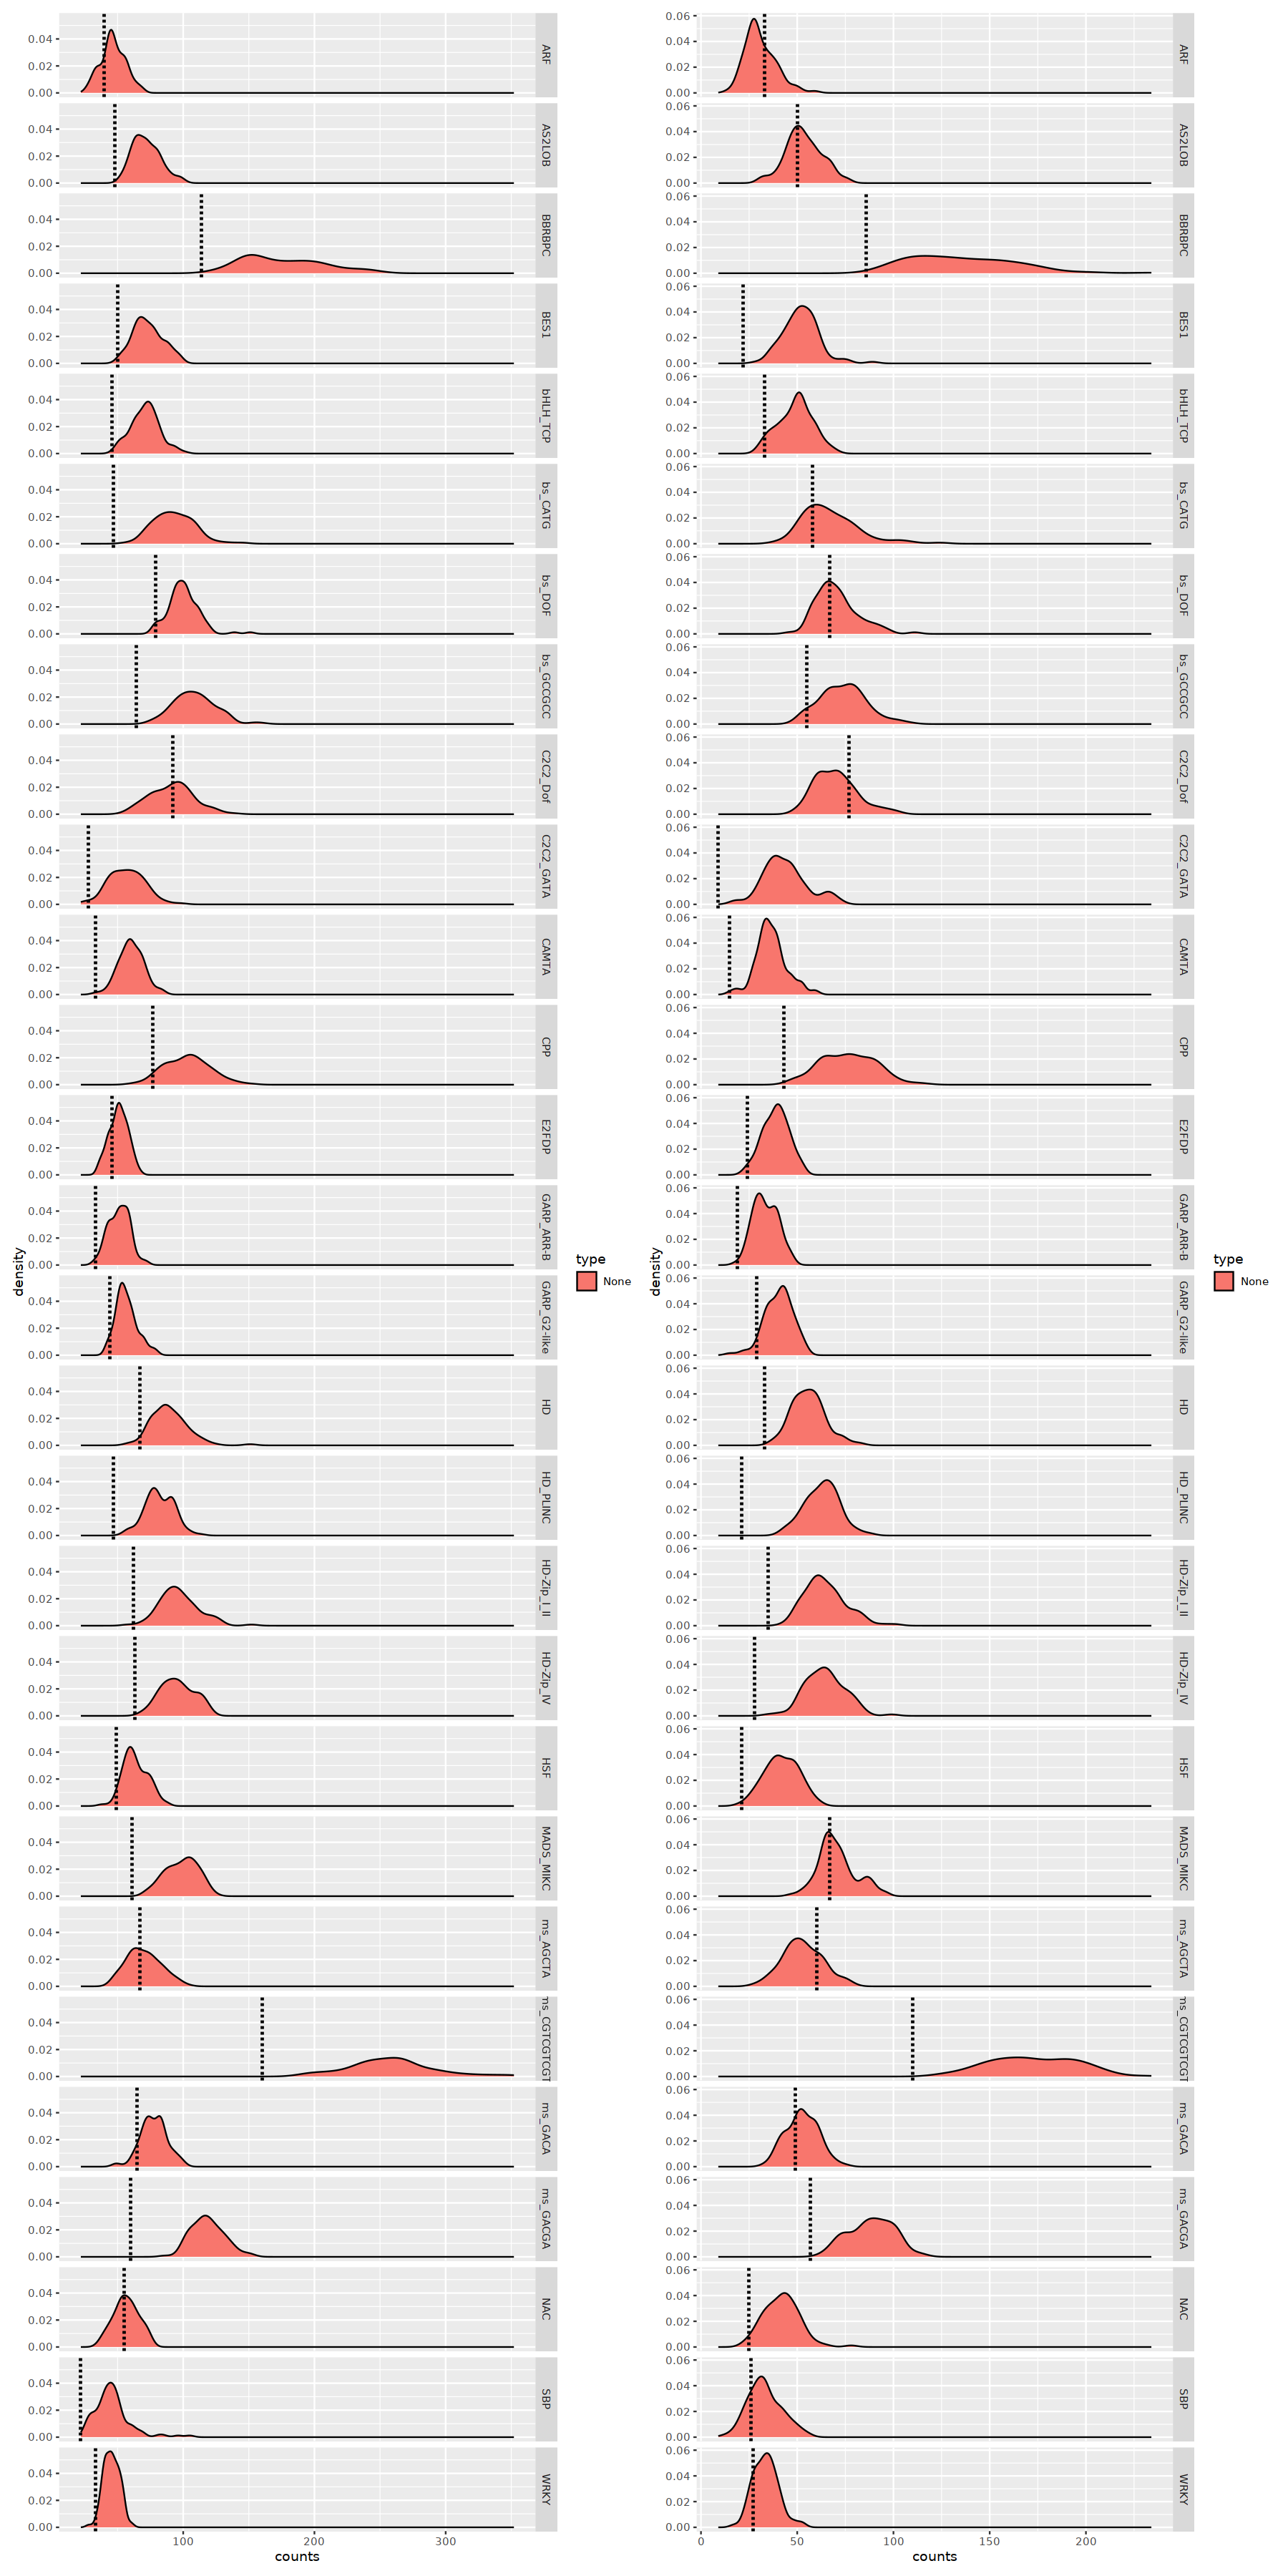

In [313]:

enzyme_family_class <- data.frame(gene_family=c("AlaAT", "AspAT", "CA", "DIC", "DIT", "NADMDH", "NADME", "NADPMDH", "NADPME", "NHD", "PEPCK", "PEPC", "PPDKRP", "PPDK", "PPT", "RBCS", "RCA", "BASS"),
                                  enzyme_class=c("variable", "variable", "core", "core", "variable", "variable", "variable", "variable", "variable", "variable", "core", "core", "core", "core", "core", "core", "core", "variable"))

combined_zm_tfs_gene_family_type_ms <- left_join(zm_acrs_TFs_c4_prescence,enzyme_family_class, by = c("gene_family")) %>% 
        dplyr::filter(type == "mesophyll") %>% 
        dplyr::group_by(TF_ID) %>% 
        summarise(counts = n()) %>% 
        dplyr::ungroup() %>% 
        mutate(sample = "real")


combined_zm_tfs_gene_family_type_bs <- left_join(zm_acrs_TFs_c4_prescence,enzyme_family_class, by = c("gene_family")) %>% 
        dplyr::filter(type == "bundle_sheath") %>% 
        dplyr::group_by(TF_ID) %>% 
        summarise(counts = n()) %>% 
        dplyr::ungroup() %>% 
        mutate(sample = "real")

options(repr.plot.width=15, repr.plot.height=30)
ms_nulls <- null_tf_counts_mesophyll %>% 
    ggplot(., aes(x = counts, fill = type)) + 
    geom_density() + facet_grid(TF_ID~.) +
    geom_vline(data = combined_zm_tfs_gene_family_type_ms, 
               aes(xintercept=(counts)),
        linetype="dashed", size=1)

bs_nulls <- null_tf_counts_bs %>% 
    ggplot(., aes(x = counts, fill = type)) + 
    geom_density() + facet_grid(TF_ID~.) +
    geom_vline(data = combined_zm_tfs_gene_family_type_bs, 
               aes(xintercept=(counts)),
        linetype="dashed", size=1)

library(patchwork)

ms_nulls + bs_nulls

In [192]:
# ora_res <- list()
# system.time({
#     for (motif_id in unique(zm_acrs_TFs$TF_ID)) {
#         subsample <- zm_acrs_TFs %>% 
#             dplyr::filter(TF_ID == motif_id) # Filter for each motif_id

#         xt <- xtabs(~ type + acr_cell_type_specific_class, data = subsample)
#         # Replace zeros with ones in the contingency table
#         xt <- apply(xt, c(1, 2), function(x) ifelse(x == 0, 1, x))
        
#         ft.ms <- fisher.test(xt[c("mesophyll", "None"), c("mesophyll", "broadly_accessible")], alternative = "greater")
#         ft.bs <- fisher.test(xt[c("bundle_sheath", "None"), c("bundle_sheath", "broadly_accessible")], alternative = "greater")
#         ft.bs_vs_ms <- fisher.test(xt[c("bundle_sheath", "mesophyll"), c("bundle_sheath", "mesophyll")], alternative = "greater")
#         ft.ms_vs_bs <- fisher.test(xt[c("mesophyll", "bundle_sheath"), c("mesophyll", "bundle_sheath")], alternative = "greater")

#         ora_res[[motif_id]] <- data.frame(
#             "Motif.ID" = motif_id,
#             "OR.ms" = unname(ft.ms$estimate), "pv.ms" = ft.ms$p.value,
#             "OR.bs" = unname(ft.bs$estimate), "pv.bs" = ft.bs$p.value,
#             "OR.bs_vs_ms" = unname(ft.bs_vs_ms$estimate), "pv.bs_vs_ms" = ft.bs_vs_ms$p.value,
#             "OR.ms_vs_bs" = unname(ft.ms_vs_bs$estimate), "pv.ms_vs_bs" = ft.ms_vs_bs$p.value
#         )
#     }
# })


# ora_res <- as.data.frame(do.call("rbind",ora_res))
# rownames(ora_res) <- NULL

# # adjust p-values for multiple testing
# ora_res$fdr.bs <- p.adjust(ora_res$pv.bs, method="BH")
# ora_res$fdr.ms   <- p.adjust(ora_res$pv.ms, method="BH") 
# ora_res$fdr.bs_vs_ms   <- p.adjust(ora_res$pv.bs_vs_ms, method="BH") 
# ora_res$fdr.ms_vs_bs   <- p.adjust(ora_res$pv.ms_vs_bs, method="BH") 



ERROR: Error in xt[c("mesophyll", "None"), c("mesophyll", "broadly_accessible")]: subscript out of bounds


Timing stopped at: 0.021 0 0.022



# Per Gene Model Motif Analysis

In [ ]:
per_loci_values <- generate_null_values_gene_models

combined_df_models <- imap_dfr(per_loci_values, ~map_df(.x, ~.x %>% 
                                            mutate(inner_index = row_number()), 
                                            .id = "nested_index") %>% 
                        mutate(locus = .y))


In [ ]:
plot_real_counts <- real_count_numer

In [ ]:
nested_null_values <- combined_df_models %>% 
    dplyr::select(-inner_index) %>% 
    group_by(locus, TF_ID) %>% 
    nest()

combined_real_null <- left_join(real_count_numer, nested_null_values, by = c("locus", "TF_ID"))

In [ ]:
pvals <- combined_real_null %>% 
    dplyr::rename(real_counts = counts) %>% 
    dplyr::rowwise() %>% 
    dplyr::mutate(passing_val = sum(data$counts > real_counts) + 1,
                  length_null = length(data$counts) + 1,
                 pval = passing_val/length_null )


saveRDS(pvals, 
        file = "/home/jpm73279/genome_downloads/C4_markers/shuffled_null_dist_storage/Zm.shuffled_null_dist.rds")
        

In [ ]:
glimpse(pvals)

In [472]:
plot_real_counts <- real_count_numer %>% 
    dplyr::filter(locus %in% combined_df_models$locus)


options(repr.plot.width=25, repr.plot.height=25)

combined_df_models %>% 
    ggplot(., aes(x = counts, fill = type)) + 
    geom_density() + facet_grid(TF_ID~locus,   scales = "free") +
    geom_vline(.,aes(xintercept=(real_counts)),
        linetype="dashed", size=1)


ERROR: Error in layer(data = data, mapping = mapping, stat = StatIdentity, geom = GeomVline, : object '.' not found
